## 1. Understanding the Problem
----
This project aims to develop a **Machine Learning model** to classify credit card transactions as legitimate or fraudulent, using a publicly available dataset from Kaggle.

The choice of a Logistic Regression model comes from the content learned in the course, where we saw that this type of model is very effective for solving classification problems with relatively simple steps.


### **1.1. Motivation**

----

**1. Professional experience:**

I currently work in the banking sector, where fraud is a recurring challenge. This professional background motivated me to choose credit card fraud detection as the topic for my first project.

**2. Real-world problem:**

Credit card fraud is a common problem in real life. Therefore, working on this project provides valuable insights and practical challenges to apply the concepts learned during the first part of the course.

### **1.2. Objectives**

----

- Build a predictive model capable of classifying transactions as fraudulent or not.
- Evaluate performance using concepts from the Evaluation chapter and select the most appropriate metrics.
- Interpret the results and identify the main factors that increase the probability of fraudulent transactions.

## 2. Dataset Informations
----
The dataset used in this project is Credit Card Fraud Detection (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data), which contains credit card transactions carried out by European cardholders in September 2013.

To protect customer privacy and sensitive information, most features have been anonymized and transformed using PCA, resulting in a dataset suitable for research with real-world data.

### **2.1. Features Description:**

----

- **Time:** Number of seconds elapsed between this transaction and the first transaction in the dataset.
- **V1 - V28:** Result of PCA transformation, used to anomyze original features realted to customers and transactions.
- **Amount:** Transaction amount.
- **Class:** Target variable – 1 for fraud, 0 for legitimate transactions.

### **2.2. Dataset Characteristics:**

----

- The dataset contains 284.807 transactions, of which 492 are fraudulent (~0,17%).
- The main challenge is the highly imbalanced nature of the dataset, which reflects a common real-world problem in fraud detection.
- The anonymization through PCA limits the interpretability of the features, but this is acceptable for tackling a realistic problem.

## 3. Downloading Dataset
----

In [1]:
!pip install kaggle --quiet
!mkdir -p ~/.kaggle

import os, json

kaggle_json = {
    "username": os.getenv("KAGGLE_USERNAME"),
    "key": os.getenv("KAGGLE_PASS")
}

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_json, f)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud -p ./data
!unzip -o ./data/creditcardfraud.zip -d ./data

zip_path = "./data/creditcardfraud.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0%|                                               | 0.00/66.0M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 1.25GB/s]
Archive:  ./data/creditcardfraud.zip
  inflating: ./data/creditcard.csv   


## 4. Libraries and Configuration
----

In [2]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

# Configurations
pd.set_option('display.max_columns',None) # exibir todas as colunas do meu df
pd.set_option("display.max_seq_items", None) # exibir todas as linhas no meu for

## 5. Exploratory Data Analysis (EDA)
----

In this section, we will explore the dataset to better understand its structure, distribuition and main characteristics before moving on the model building.

In [3]:
df = pd.read_csv('data/creditcard.csv')
df.columns = df.columns.str.lower().str.strip().str.replace(' ','_')

### **5.1. Dataset Overview**
----
- 284.807 columns.
- 31 features.
- No null columns.
- All features are a float column and the target is binarie (0/1).
- 492 fraud | 0,173 % fraud ratio.

In [4]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print(f'The dataset have {df.shape[0]} transactions with {df.shape[1]} features.')

The dataset have 284807 transactions with 31 features.


In [6]:
df.dtypes

time      float64
v1        float64
v2        float64
v3        float64
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22       float64
v23       float64
v24       float64
v25       float64
v26       float64
v27       float64
v28       float64
amount    float64
class       int64
dtype: object

In [7]:
df.isnull().sum()
# No null columns

time      0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       0
v11       0
v12       0
v13       0
v14       0
v15       0
v16       0
v17       0
v18       0
v19       0
v20       0
v21       0
v22       0
v23       0
v24       0
v25       0
v26       0
v27       0
v28       0
amount    0
class     0
dtype: int64

In [8]:
global_fraud = df['class'].mean()
print(f'We have {df['class'].sum()} frauds with {(global_fraud*100).round(3)}% of fraud ratio.')

We have 492 frauds with 0.173% of fraud ratio.


### **5.2. Chart Visualizations**
----
- **General:**
  - 492 / 284.315 | fraud / legit
- **Time:**
  - We can observe a concentration of fraudulent transactions during uncommon hours. Looking at the lowest concentration of legitimate transactions, we can identify the peak periods for fraud, indicating that the time of day is an important feature.
- **Amount:**
  - On the other hand, the transaction amount does not seem to be a critical feature, as the highest values are concentrated in legitimate transactions.
- **PCA Features:**
  - Some variables show a clear difference in distribution between fraudulent and legitimate transactions, indicating that they are likely to play a strong role in classification. In the other hand, other variables present almost identical distributions across classes, suggesting limited predictive power.
  - Features v3, v4, v7, v9, v10, v11, v12, v14, v16, v17 and v18 stand out as having high predictive power.

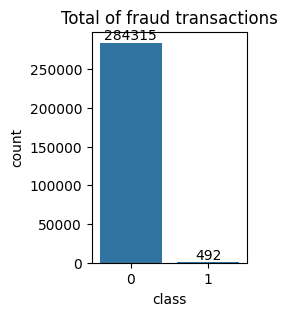

In [9]:
# General Information

plt.figure(figsize=(2,3))
ax = sns.countplot(x='class', data=df)
plt.title('Total of fraud transactions')

ax.bar_label(ax.containers[0])

plt.show()

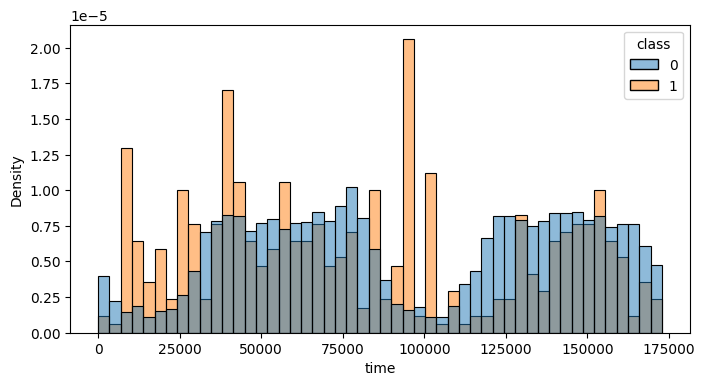

In [10]:
# Time Distribution

plt.figure(figsize=(8,4))
sns.histplot(data=df, bins=50, x='time', hue='class', stat='density', common_norm=False)
plt.show()

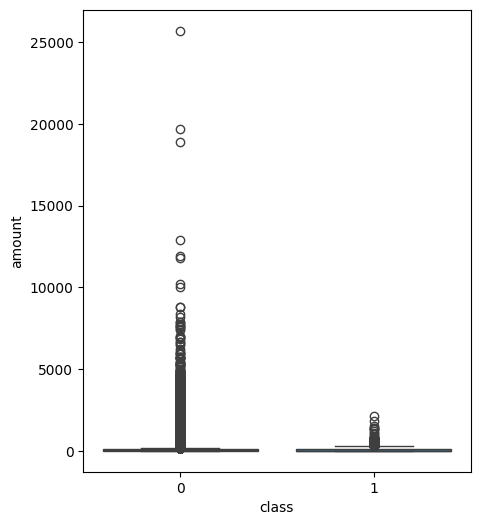

In [11]:
# Amount Distribution

plt.figure(figsize=(5,6))
sns.boxplot(x='class', y='amount', data=df)
plt.show()

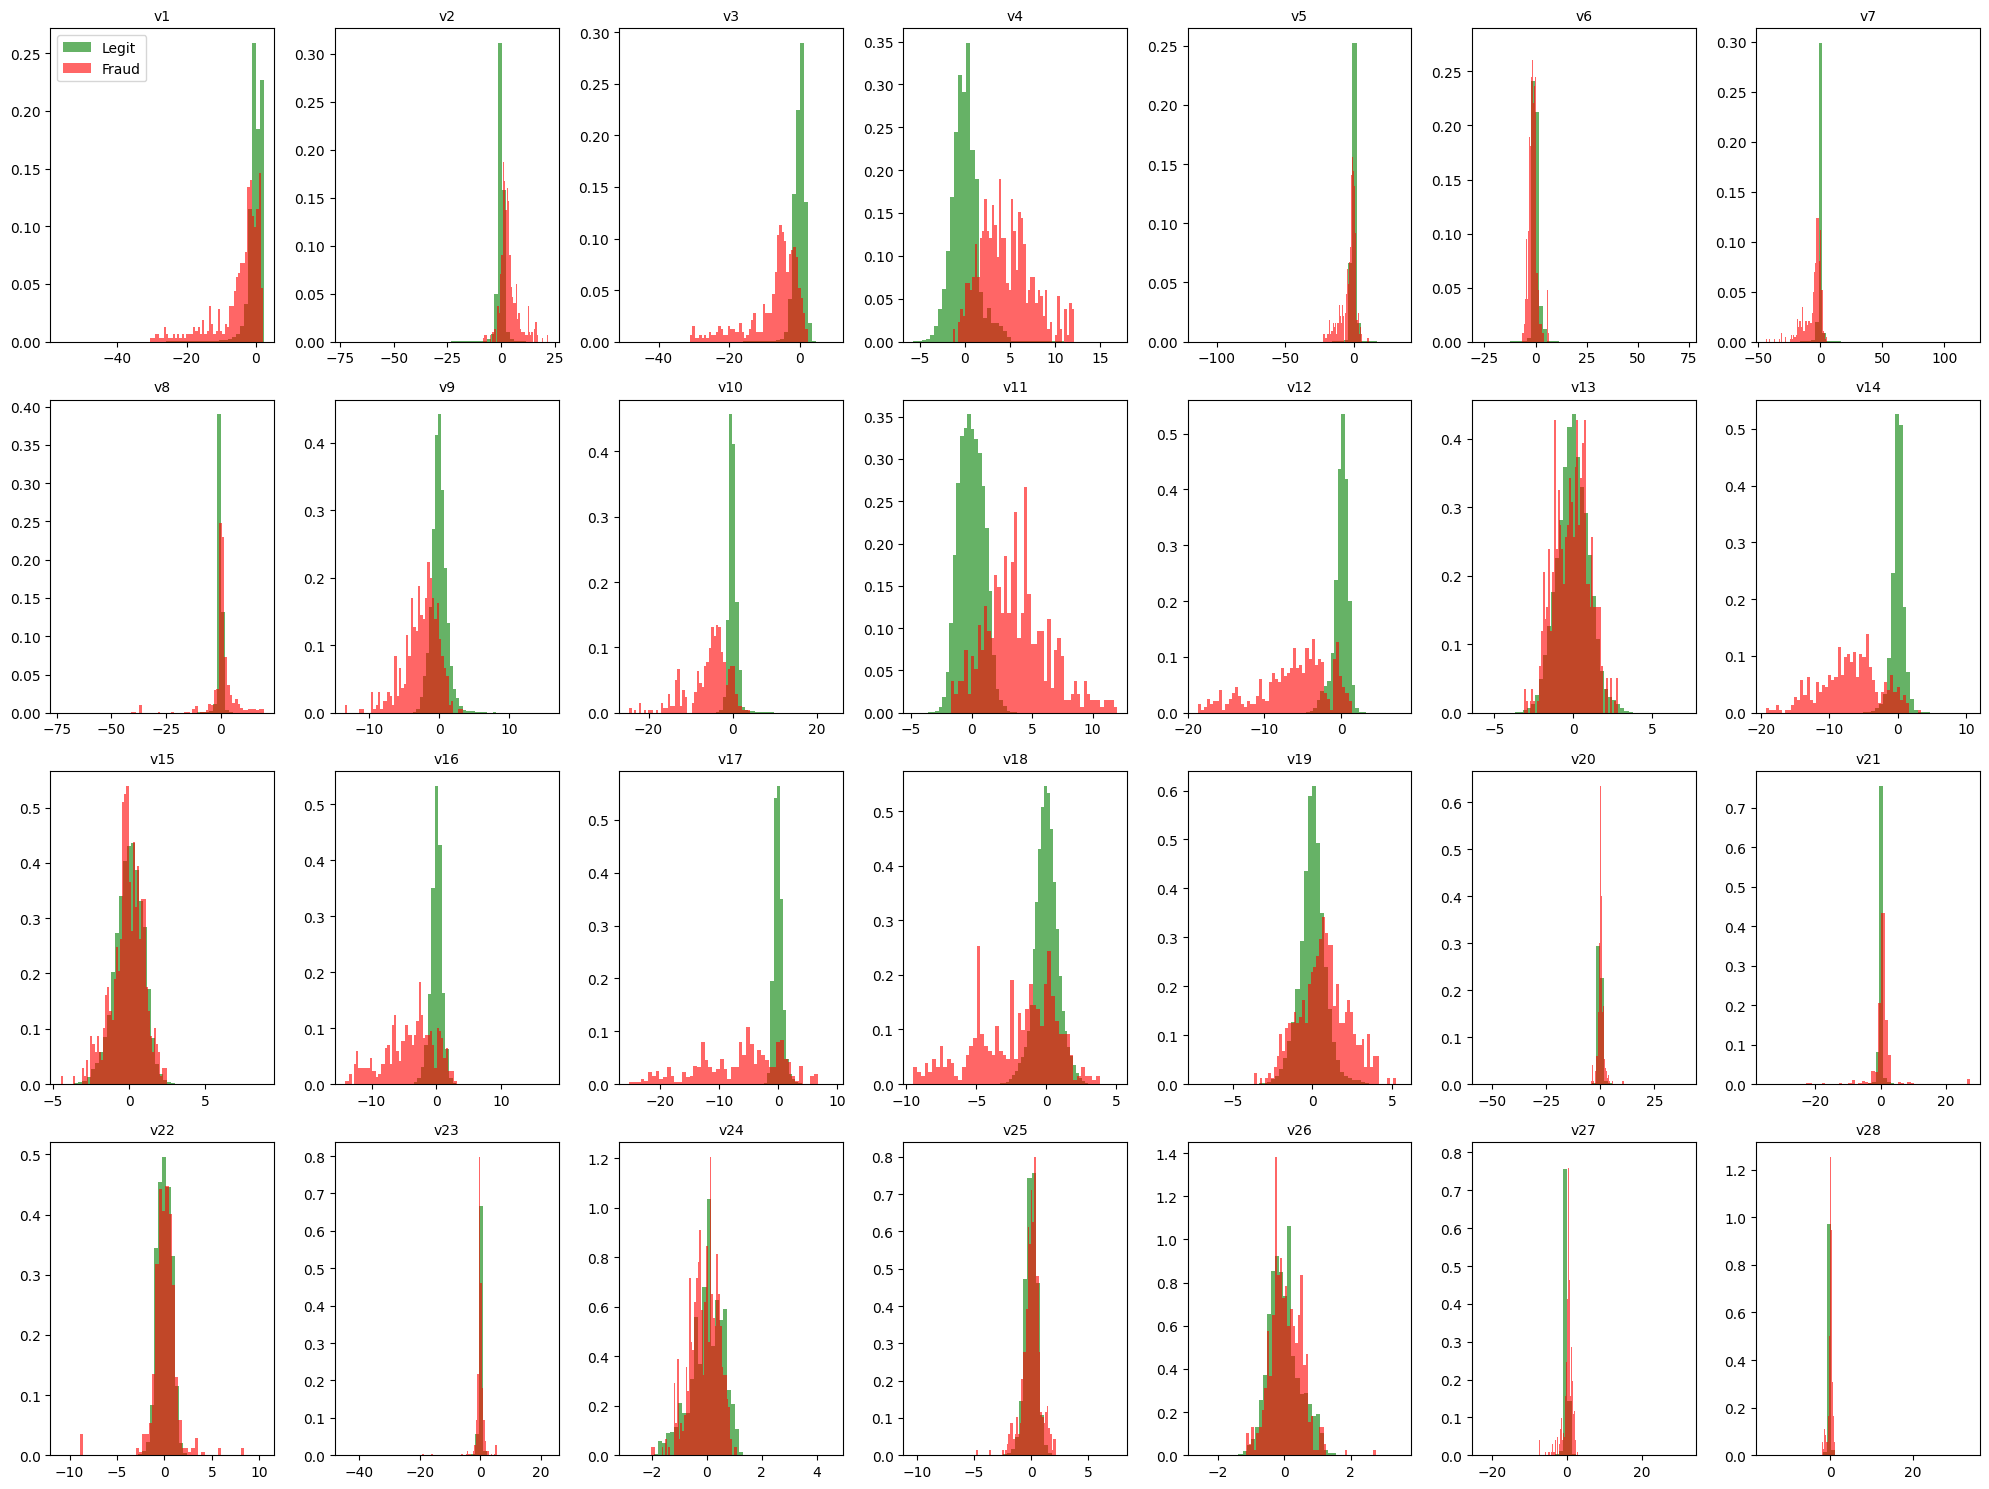

In [12]:
# General Features

features = [f'v{i}' for i in range(1,29)]

plt.figure(figsize=(20,15))

for i, col in enumerate(features, 1):
    plt.subplot(4,7,i)
    plt.hist(df[df['class']==0][col], bins=50, alpha=0.6, label='Legit', color='green', density=True)
    plt.hist(df[df['class']==1][col], bins=50, alpha=0.6, label='Fraud', color='red', density=True)
    plt.title(col, fontsize=10)
    if i == 1:
        plt.legend()
    plt.tight_layout()

plt.show()

### **5.3. Correlations**
----
- We analyzed the correlation of each feature with the fraud label in the transactions. When considering the absolute values (to capture negative correlations), the results align with the chart analysis from the previous step.
- We observe that more variables are associated with legitimate transactions than with fraudulent ones. Given our highly imbalanced dataset, features showing a correlation with the target around 0.2 appear particularly interesting.
- Two features show positive correlations of 0.15 and 0.13, which merit further attention in future analyses.


In [23]:
corr_target = df.corr()['class'].sort_values(ascending=False, key=abs)
print(corr_target)

class     1.000000
v17      -0.326481
v14      -0.302544
v12      -0.260593
v10      -0.216883
v16      -0.196539
v3       -0.192961
v7       -0.187257
v11       0.154876
v4        0.133447
v18      -0.111485
v1       -0.101347
v9       -0.097733
v5       -0.094974
v2        0.091289
v6       -0.043643
v21       0.040413
v19       0.034783
v20       0.020090
v8        0.019875
v27       0.017580
time     -0.012323
v28       0.009536
v24      -0.007221
amount    0.005632
v13      -0.004570
v26       0.004455
v15      -0.004223
v25       0.003308
v23      -0.002685
v22       0.000805
Name: class, dtype: float64
